In [1]:
import os
os.environ['OMP_NUM_THREADS']='2'
os.environ['LD_LIBRARY_PATH']=''
os.environ['CUDA_LAUNCH_BLOCKING']='1'

In [2]:
%cd /home/pz281@ad.eng.cam.ac.uk/mnt/PhD/Probabilistic_SR

/home/pz281@ad.eng.cam.ac.uk/mnt/PhD/Probabilistic_SR


In [3]:
from data_generation import *
from utils import *
from upscaling import UpScale
from downscaling import *

/home/pz281@ad.eng.cam.ac.uk/anaconda3/envs/torch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
N_low = 16
N_high = 128
l = 1
sigma = 0.005

In [5]:
w_low, r_low, A_low, x_low, y_low = generate_data(N_low)
w_high, r_high, A_high, x_high, y_high = generate_data(N_high)

In [6]:
with h5py.File('data/100_from_uhigh_1_5e-3.h5', 'r') as hf:
    data_high = hf['high_res'][:]
    data_low = hf['low_res'][:]

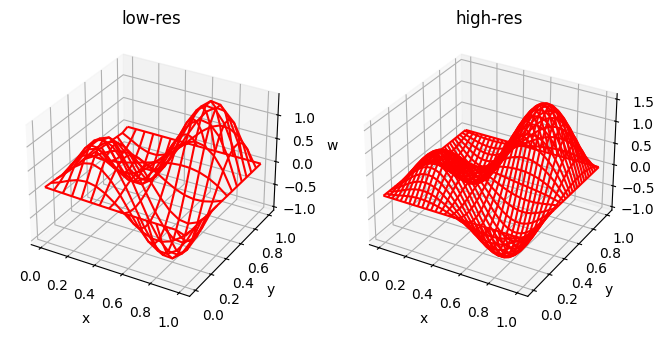

In [7]:
num = 17
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(121, projection='3d')
X, Y = np.meshgrid(x_low, y_low)
ax1.plot_wireframe(X, Y, data_low[num],color='r')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('w')
ax1.set_title('low-res')
ax2 = fig.add_subplot(122, projection='3d')
X, Y = np.meshgrid(x_high,y_high)
ax2.plot_wireframe(X, Y, data_high[num],color='r')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('w')
ax2.set_title('high-res')
plt.show()

### Test difference l and sigma values for u_high

In [34]:
l = 1
sigma = 0.002
mean_u, covariance_u = u_prior(l,sigma,N_high)

In [35]:
w_sample = np.random.multivariate_normal(mean_u.ravel(),covariance_u)

Text(0.5, 0.92, 'low-res')

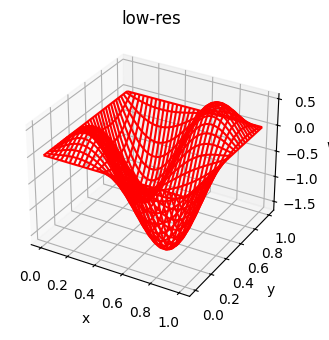

In [36]:
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(121, projection='3d')
X, Y = np.meshgrid(x_high, y_high)
ax1.plot_wireframe(X, Y, w_sample.reshape(64,64),color='r')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('w')
ax1.set_title('low-res')

### Training downscale network with pairs of u_low and u_high

In [9]:
epoch_num = 500
batch_size = 16
lr = 0.01
gamma = 0.5
minimum_loss = float('inf')
loss_track = []
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load training data
trainset = DataFromH5File2("data/100_from_uhigh_e-1_5e-2.h5")
train_loader = data.DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True)

# Initialise training model
G = DownScale()
G.apply(weights_init_xavier).to(device)
mse = nn.MSELoss(reduction='sum')
optG = torch.optim.Adam(G.parameters(), lr = lr, weight_decay=0, betas=(0.5, 0.999))
r_scheduleG = torch.optim.lr_scheduler.StepLR(optG, step_size=50, gamma=gamma)

# Logger info
dir_name = f'models/downscaling/100samples/lr{lr}_gamma{gamma}'
makedir(dir_name)
logger = setup_logging('job0', dir_name, console=True)
logger.info(f'Training for {epoch_num} epoches and learning rate is {lr}')

for epoch in range(1, epoch_num+1):
    
    for i, d in enumerate(train_loader, 0):
        
        lr, hr = d
        size = lr.shape[0]
        lr = lr.to(device).reshape(size,1,N_low,N_low)
        hr = hr.to(device).reshape(size,1,N_high,N_high)
        
        optG.zero_grad()
        sr = G(hr)
        loss = mse(sr,lr)/batch_size
        loss.backward()
        optG.step()
        
        if loss < minimum_loss:
            save_model(dir_name, epoch, 'best_model', r_scheduleG, G, optG)
            minimum_loss = loss
            
        if epoch%100 == 0:
            save_model(dir_name, epoch, 'model_epoch_{}'.format(epoch), r_scheduleG, G, optG)
            
        loss_track.append(loss.cpu().data.numpy())
        np.save(f'{dir_name}/chains/loss_curve.npy', np.array(loss_track))
        
        print("Epoch:", epoch, "Loss:", loss)

        r_scheduleG.step()

Output directory already exists
2024-02-19 00:16:04,348 : Training for 500 epoches and learning rate is 0.01
Epoch: 1 Loss: tensor(2289.3972, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 1 Loss: tensor(2528.2852, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 1 Loss: tensor(2206.3274, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 1 Loss: tensor(1073.9375, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 1 Loss: tensor(1945.7473, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 1 Loss: tensor(692.2770, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 1 Loss: tensor(158.6515, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 2 Loss: tensor(761.1572, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 2 Loss: tensor(894.2403, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 2 Loss: tensor(446.5336, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 2 Loss: tensor(1045.5466, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 2 Loss: tensor(552.2987, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 2 

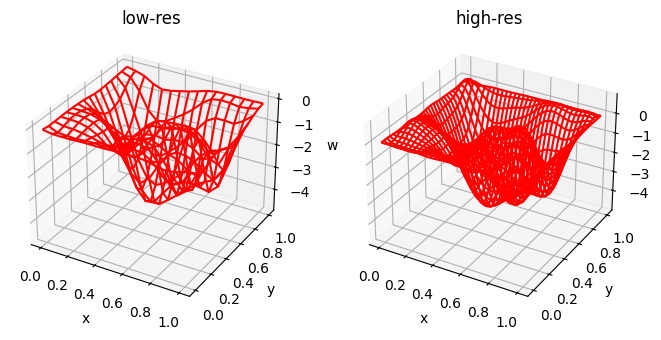

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
G = DownScale().to(device)
G.load_state_dict(torch.load('models/downscaling/100samples/lr0.01_gamma0.5/ckpt/best_model.pth')['netG'])
input = data_high[10]
input = torch.tensor(input.reshape(1,input.shape[0],-1))
input = input.to(torch.float32).to(device)
output = G(input)
y_input = input.cpu().detach().numpy()
y = output.cpu().detach().numpy()

fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(121, projection='3d')
X, Y = np.meshgrid(x_low, y_low)
ax1.plot_wireframe(X, Y, y[0].reshape(16,16),color='r')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('w')
ax1.set_title('low-res')
ax2 = fig.add_subplot(122, projection='3d')
X, Y = np.meshgrid(x_high,y_high)
ax2.plot_wireframe(X, Y, input[0].cpu().detach().numpy().reshape(64,64),color='r')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('w')
ax2.set_title('high-res')
plt.show()


### Langevin dynamics and training downscaling network

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mean_u, covariance_u = u_prior(l,sigma,N_high)
covariance = torch.tensor(covariance_u).to(device).to(torch.float32)
positive_covariance = covariance + 1e-5 * torch.eye(4096).to(device)
sqrt_covariance = torch.tensor(sqrt_matrix(positive_covariance)).to(device).to(torch.float32)

/tmp/ipykernel_533983/1185356177.py:5: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /opt/conda/conda-bld/pytorch_1670525551200/work/aten/src/ATen/native/Copy.cpp:250.)
  sqrt_covariance = torch.tensor(sqrt_matrix(positive_covariance)).to(device).to(torch.float32)


In [12]:
def sample_p_data():
    data = torch.tensor(data_low.reshape(100,1,N_low,N_low)).to(torch.float32).to(device)
    return data[torch.LongTensor(batch_size).random_(0,100)].detach()

def sample_p_0(batch_size):
    # Randomly sampling for initialisation of the Langevin dynamics
    # prior = torch.randn(*[batch_size,1,20,20]).to(device)
    
    # Set the u_low_mean to the initialisation of the Langevin dynamics
    mean = w_high.reshape(1,1,N_high,N_high)
    b = np.repeat(mean,batch_size,axis=0)
    prior = torch.tensor(b).to(device).to(torch.float32)
    # prior = prior + 0.1 * torch.rand_like(prior)
    
    return prior

def calculate_log_likelihood(x_hat,x,batch_size):
    ll = -1/(2*math.pow(ll_sigma, 2)) * torch.matmul((x-x_hat).reshape(batch_size,1,N_low**2),(x-x_hat).reshape(batch_size,N_low**2,1))
    # ll = -1/(2*math.pow(ll_sigma, 2)) * mse(x_hat,x)
    # ll = -torch.norm(x - x_hat, dim=-1) ** 2. / (2. * ll_sigma ** 2.)
    return ll.sum()


def ula_posterior_preconditioner(z, x, G):
    """
    Langevin dynamics with preconditioner
    """
    z = z.clone().detach().requires_grad_(True)
    chains_evolution = []
    preconditioner = covariance
    for i in range(K):
        # Grad log-likelihood
        x_hat = G(z)
        log_likelihood = calculate_log_likelihood(x_hat,x,batch_size)
        grad_ll = torch.autograd.grad(log_likelihood, z)[0]
        grad_log_likelihood = torch.matmul(covariance,grad_ll.reshape(batch_size,N_high**2,1)).reshape(batch_size,1,N_high,N_high)

        # Grad prior
        w_high_tensor = torch.tensor(w_high).to(device).to(torch.float32)
        difference = z.reshape(batch_size,1,N_high**2) - w_high_tensor.reshape(1,N_high**2)
        grad_log_prior = - difference.reshape(batch_size,1,N_high,N_high)

        # Random noise term
        W = torch.randn(*[batch_size,1,N_high,N_high]).to(device)
        random = torch.matmul(sqrt_covariance,W.reshape(batch_size,N_high**2,1)).reshape(batch_size,1,N_high,N_high)

        z = z + 0.5 * s ** 2 * grad_log_prior + 0.5 * s ** 2 * grad_log_likelihood + s * random
        chains_evolution.append(z.cpu().data.numpy())   
           
    return z.detach(), chains_evolution

In [51]:
# Train with sampled data
epoch_num = 100
batch_size = 8
lr = 0.01
gamma = 0.5
K = 80
s = 0.0003
ll_sigma = 0.005
minimum_loss = float('inf')
loss_track = []

G = DownScale()
G.apply(weights_init_xavier).to(device)
mse = nn.MSELoss(reduction='sum')
optG = torch.optim.Adam(G.parameters(), lr = lr, weight_decay=0, betas=(0.5, 0.999))
r_scheduleG = torch.optim.lr_scheduler.StepLR(optG, step_size=30, gamma=gamma)

# Logger info
dir_name = f'models/probabilistic_downscale_training/100samples/lr{lr}_gamma{gamma}'
makedir(dir_name)
logger = setup_logging('job0', dir_name, console=True)
logger.info(f'Training for {epoch_num} epoches and learning rate is {lr}')

for epoch in range(1, epoch_num+1):
    
    x = sample_p_data()
    posterior_initial = sample_p_0(batch_size)
    posterior_final, posterior_chain = ula_posterior_preconditioner(posterior_initial, x, G)

    optG.zero_grad()
    x_hat = G(posterior_final.detach())
    loss = mse(x_hat, x)/batch_size
    loss.backward()
    optG.step()
    
    if loss < minimum_loss:
        save_model(dir_name, epoch, 'best_model', r_scheduleG, G, optG)
        minimum_loss = loss
            
    if epoch%100 == 0:
        save_model(dir_name, epoch, 'model_epoch_{}'.format(epoch), r_scheduleG, G, optG)
        
    loss_track.append(loss.cpu().data.numpy())
    np.save(f'{dir_name}/chains/loss_curve.npy', np.array(loss_track))
    
    print("Epoch:", epoch, "Loss:", loss)

    r_scheduleG.step()

Output directory already exists
2024-02-19 23:00:43,900 : Training for 100 epoches and learning rate is 0.01
Epoch: 1 Loss: tensor(147.5973, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 2 Loss: tensor(139.9715, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 3 Loss: tensor(139.6553, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 4 Loss: tensor(158.6453, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 5 Loss: tensor(156.8584, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 6 Loss: tensor(95.6526, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 7 Loss: tensor(142.4889, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 8 Loss: tensor(146.9223, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 9 Loss: tensor(107.6089, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 10 Loss: tensor(139.1555, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 11 Loss: tensor(111.5012, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 12 Loss: tensor(129.6450, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 13 Los

### Testing

In [40]:
G = DownScale().to(device)
G.load_state_dict(torch.load('models/probabilistic_downscale_training/100samples/lr0.01_gamma0.5/ckpt/best_model.pth')['netG'])
batch_size = 1
x = torch.tensor(w_low).to(torch.float32).to(device).reshape(1,1,N_low,N_low)
z = sample_p_0(batch_size)
z = z.clone().detach().requires_grad_(True)
K = 80
s = 0.0003
ll_sigma = 0.005
posterior_final, posterior_chain = ula_posterior_preconditioner(z, x, G)

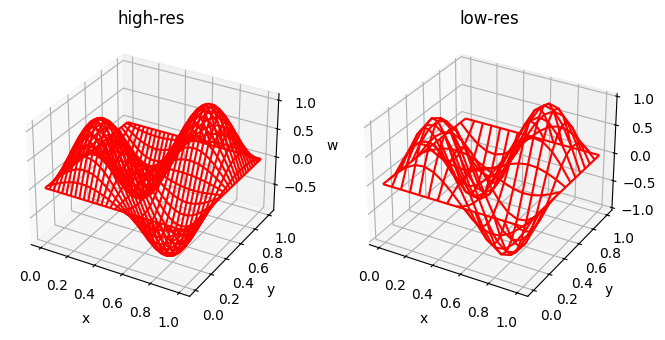

In [14]:
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(121, projection='3d')
X, Y = np.meshgrid(x_high, y_high)
ax1.plot_wireframe(X, Y, posterior_final.cpu().data.numpy()[0][0],color='r')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('w')
ax1.set_title('high-res')
ax2 = fig.add_subplot(122, projection='3d')
X, Y = np.meshgrid(x_low,y_low)
ax2.plot_wireframe(X, Y, x.detach().cpu()[0][0],color='r')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('w')
ax2.set_title('low-res')
plt.show()

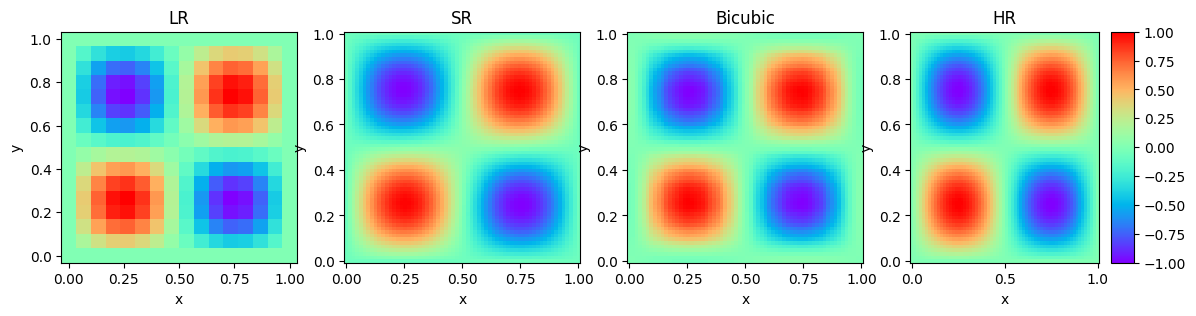

SR L2 Error: 0.0034651426081815763
Bicubic L2 Error: 0.00506826790119665


In [20]:
fig = plt.figure(figsize=(14,3))
plt.subplot(1,4,1)
plt.pcolormesh(x_low, y_low, x.detach().cpu()[0][0], cmap='rainbow')
#cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(-1, 1)
plt.title('LR')
plt.xlabel('x')
plt.ylabel('y')
plt.subplot(1,4,2)
plt.pcolormesh(x_high, y_high, posterior_final.cpu().data.numpy()[0][0], cmap='rainbow')
#cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(-1, 1)
plt.title('SR')
plt.xlabel('x')
plt.ylabel('y')
plt.subplot(1,4,3)
lr = x.detach().cpu().numpy()[0][0]
w_high_bicubic = cv2.resize(lr, dsize=(64,64), interpolation=cv2.INTER_CUBIC)
plt.pcolormesh(x_high, y_high, w_high_bicubic, cmap='rainbow')
#cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(-1, 1)
plt.title('Bicubic')
plt.xlabel('x')
plt.ylabel('y')
# Around 200 epochs
plt.subplot(1,4,4)
plt.pcolormesh(x_high, y_high, w_high, cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
cbar.mappable.set_clim(-1, 1)
plt.title('HR')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

error1 = abs(w_high - posterior_final.cpu().data.numpy()[0][0])
error2 = abs(w_high_bicubic - w_high)
print('SR L2 Error:', (error1**2).sum()/error1.shape[0]**2)
print('Bicubic L2 Error:', (error2**2).sum()/error2.shape[0]**2)

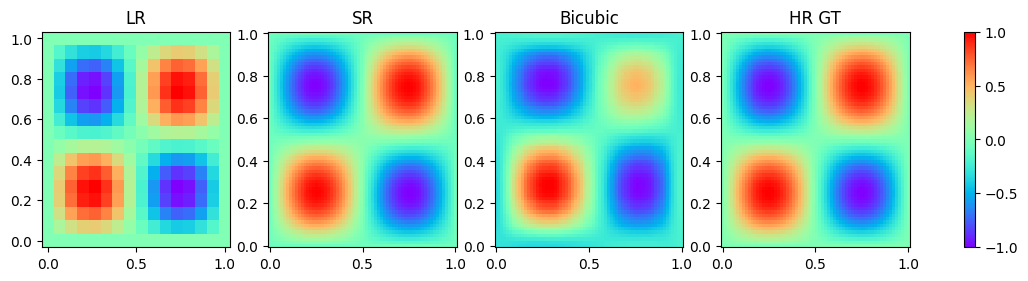

SR L2 Error: 0.003446463815841558
Bicubic L2 Error: 0.04557166881325533


In [41]:

fig = plt.figure(figsize=(14,2.8))
ax = fig.add_subplot(141)
bx = fig.add_subplot(142)
cx = fig.add_subplot(143)
dx = fig.add_subplot(144)
a = ax.pcolormesh(x_low, y_low, x.detach().cpu()[0][0], cmap=plt.get_cmap('rainbow'))
b = bx.pcolormesh(x_high, y_high, posterior_final.cpu().data.numpy()[0][0], cmap=plt.get_cmap('rainbow'))
c = cx.pcolormesh(x_high, y_high, w_high_bicubic, cmap=plt.get_cmap('rainbow'))
d = dx.pcolormesh(x_high, y_high, w_high, cmap=plt.get_cmap('rainbow'))
fig.colorbar(a, ax=[ax, bx, cx, dx])
# fig.colorbar(a, ax=ax, shrink=0.5)
# fig.colorbar(b, ax=bx, shrink=0.5)
ax.set_title("LR")
bx.set_title("SR")
cx.set_title("Bicubic")
dx.set_title("HR GT")
plt.show()
error1 = abs(w_high - posterior_final.cpu().data.numpy()[0][0])
error2 = abs(w_high_bicubic - w_high)
print('SR L2 Error:', (error1**2).sum()/error1.shape[0]**2)
print('Bicubic L2 Error:', (error2**2).sum()/error2.shape[0]**2)

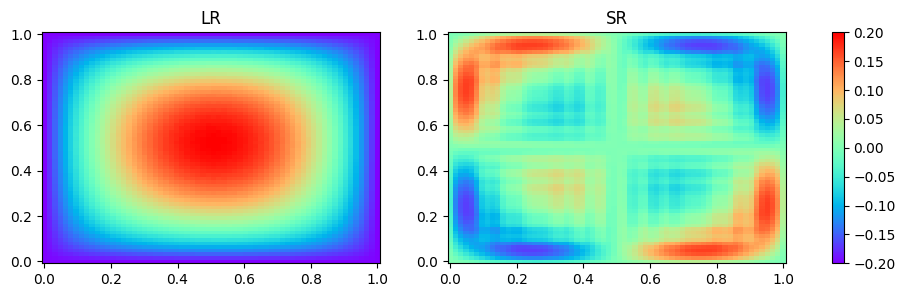

In [33]:

fig = plt.figure(figsize=(12,3))
ax = fig.add_subplot(121)
bx = fig.add_subplot(122)
a = ax.pcolormesh(x_high, y_high, posterior_final.cpu().data.numpy()[0][0]-w_high, cmap=plt.get_cmap('rainbow'))
lr = x.detach().cpu().numpy()[0][0]
w_high_bicubic = cv2.resize(lr, dsize=(64,64), interpolation=cv2.INTER_CUBIC)
b = bx.pcolormesh(x_high, y_high, w_high_bicubic-w_high, cmap=plt.get_cmap('rainbow'))
cbar = fig.colorbar(b, ax=[ax, bx])
cbar.mappable.set_clim(-0.2,0.2)
ax.set_title("LR")
bx.set_title("SR")
plt.show()

Text(0, 0.5, 'y')

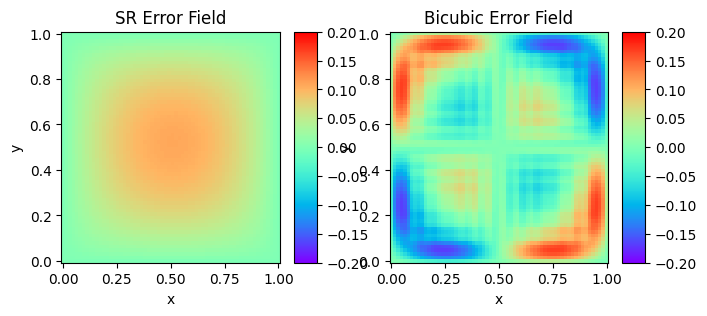

In [34]:
fig = plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.pcolormesh(x_high, y_high, posterior_final.cpu().data.numpy()[0][0]-w_high, cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
cbar.mappable.set_clim(-0.2,0.2)
plt.title('SR Error Field')
plt.xlabel('x')
plt.ylabel('y')
plt.subplot(1,3,2)
lr = x.detach().cpu().numpy()[0][0]
w_high_bicubic = cv2.resize(lr, dsize=(64,64), interpolation=cv2.INTER_CUBIC)
plt.pcolormesh(x_high, y_high, w_high_bicubic-w_high, cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
cbar.mappable.set_clim(-0.2,0.2)
plt.title('Bicubic Error Field')
plt.xlabel('x')
plt.ylabel('y')

In [35]:
with h5py.File('data/100_from_uhigh_1_5e-3.h5', 'r') as hf:
    data_high = hf['high_res'][:]
    data_low = hf['low_res'][:]

In [36]:
G = DownScale().to(device)
G.load_state_dict(torch.load('models/probabilistic_downscale_training/100samples/lr0.01_gamma0.5/ckpt/best_model.pth')['netG'])
batch_size = 1
num = 90
K = 200
x = torch.tensor(data_low[num]).to(torch.float32).to(device).reshape(1,1,N_low,N_low)
z = sample_p_0(batch_size)
z = z.clone().detach().requires_grad_(True)
posterior_final, posterior_chain = ula_posterior_preconditioner(z, x, G)

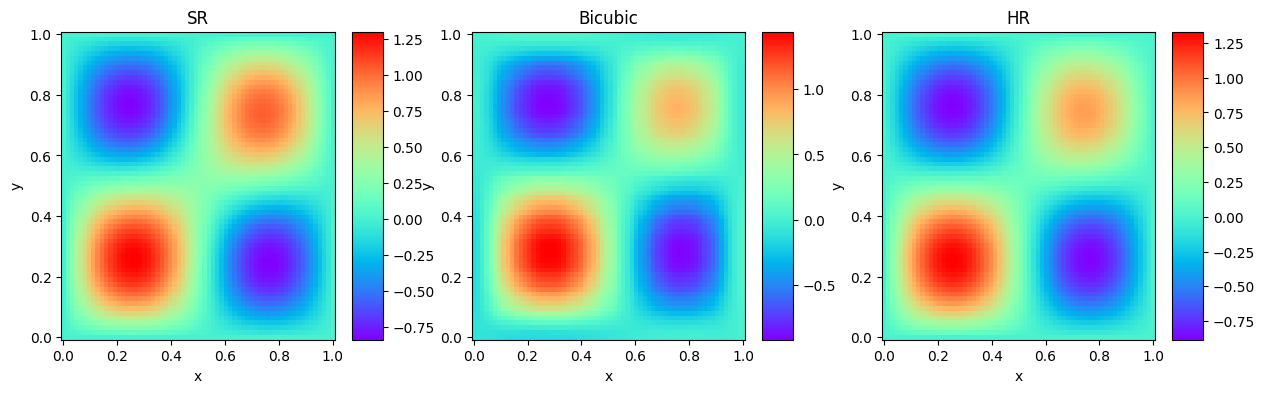

SR L2 Error: 0.00635437419837726
Bicubic L2 Error: 0.012439669641933104


In [23]:
fig = plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.pcolormesh(x_high, y_high, posterior_final.cpu().data.numpy()[0][0], cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(0, 0.15)
plt.title('SR')
plt.xlabel('x')
plt.ylabel('y')
plt.subplot(1,3,2)
lr = x.detach().cpu().numpy()[0][0]
w_high_bicubic = cv2.resize(lr, dsize=(64,64), interpolation=cv2.INTER_CUBIC)
plt.pcolormesh(x_high, y_high, w_high_bicubic, cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(0, 0.15)
plt.title('Bicubic')
plt.xlabel('x')
plt.ylabel('y')
# Around 200 epochs
plt.subplot(1,3,3)
plt.pcolormesh(x_high, y_high, data_high[num], cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(0, 0.15)
plt.title('HR')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

error1 = abs(data_high[num] - posterior_final.cpu().data.numpy()[0][0])
error2 = abs(w_high_bicubic - data_high[num])
print('SR L2 Error:', (error1**2).sum()/error1.shape[0]**2)
print('Bicubic L2 Error:', (error2**2).sum()/error2.shape[0]**2)

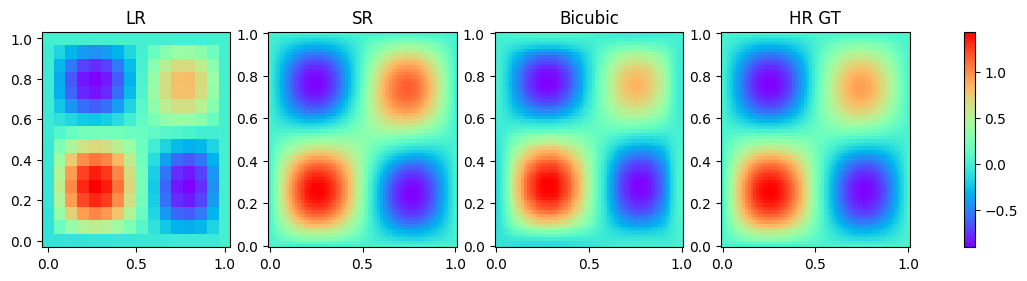

SR L2 Error: 0.0063862637382566066
Bicubic L2 Error: 0.012439669641933104


In [38]:

fig = plt.figure(figsize=(14,2.8))
ax = fig.add_subplot(141)
bx = fig.add_subplot(142)
cx = fig.add_subplot(143)
dx = fig.add_subplot(144)
lr = x.detach().cpu().numpy()[0][0]
a = ax.pcolormesh(x_low, y_low, lr, cmap=plt.get_cmap('rainbow'))
b = bx.pcolormesh(x_high, y_high, posterior_final.cpu().data.numpy()[0][0], cmap=plt.get_cmap('rainbow'))
w_high_bicubic = cv2.resize(lr, dsize=(64,64), interpolation=cv2.INTER_CUBIC)
c = cx.pcolormesh(x_high, y_high, w_high_bicubic, cmap=plt.get_cmap('rainbow'))
d = dx.pcolormesh(x_high, y_high, data_high[num], cmap=plt.get_cmap('rainbow'))
fig.colorbar(a, ax=[ax, bx, cx, dx])
# fig.colorbar(a, ax=ax, shrink=0.5)
# fig.colorbar(b, ax=bx, shrink=0.5)
ax.set_title("LR")
bx.set_title("SR")
cx.set_title("Bicubic")
dx.set_title("HR GT")
plt.show()
error1 = abs(data_high[num] - posterior_final.cpu().data.numpy()[0][0])
error2 = abs(w_high_bicubic - data_high[num])
print('SR L2 Error:', (error1**2).sum()/error1.shape[0]**2)
print('Bicubic L2 Error:', (error2**2).sum()/error2.shape[0]**2)

Text(0, 0.5, 'y')

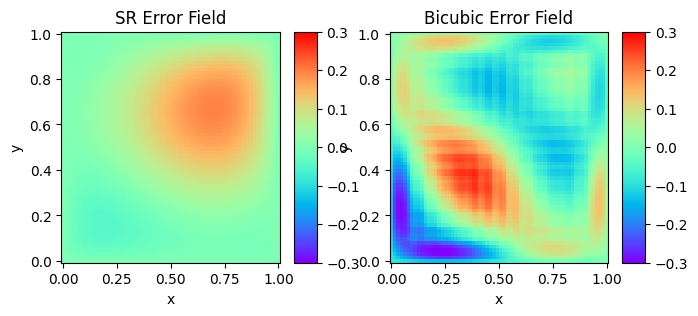

In [28]:
fig = plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.pcolormesh(x_high, y_high, posterior_final.cpu().data.numpy()[0][0]-data_high[num], cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
cbar.mappable.set_clim(-0.3,0.3)
plt.title('SR Error Field')
plt.xlabel('x')
plt.ylabel('y')
plt.subplot(1,3,2)
lr = x.detach().cpu().numpy()[0][0]
w_high_bicubic = cv2.resize(lr, dsize=(64,64), interpolation=cv2.INTER_CUBIC)
plt.pcolormesh(x_high, y_high, w_high_bicubic-data_high[num], cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
cbar.mappable.set_clim(-0.3,0.3)
plt.title('Bicubic Error Field')
plt.xlabel('x')
plt.ylabel('y')

In [26]:
(w_high_bicubic-data_high[num]).min()

-0.3056921176977863

### Test Langevin dynamics using trained model

In [76]:
x = sample_p_data()
z = sample_p_0(batch_size)
z = z.clone().detach().requires_grad_(True)

In [26]:
K = 80
s = 0.0001
ll_sigma = 0.005

In [27]:
batch_size = 1
x = torch.tensor(data_low[2]).to(torch.float32).to(device).reshape(1,1,16,16)
z = sample_p_0(batch_size)
z = z.clone().detach().requires_grad_(True)
posterior_final, posterior_chain = ula_posterior_preconditioner(z, x, G)

In [54]:
G = DownScale().to(device)
G.load_state_dict(torch.load('models/downscaling/100samples/lr0.01_gamma0.5/ckpt/best_model.pth')['netG'])
x_hat = G(z)
log_likelihood = calculate_log_likelihood(x_hat,x,batch_size)
grad_ll = torch.autograd.grad(log_likelihood, z)[0]
grad_log_likelihood = torch.matmul(covariance,grad_ll.reshape(batch_size,N_high**2,1)).reshape(batch_size,1,N_high,N_high)

# Grad prior
w_high_tensor = torch.tensor(w_high).to(device).to(torch.float32)
difference = z.reshape(batch_size,1,N_high**2) - w_high_tensor.reshape(1,N_high**2)
grad_log_prior = - difference.reshape(batch_size,1,N_high,N_high)

# Random noise term
W = torch.randn(*[batch_size,1,N_high,N_high]).to(device)
random = torch.matmul(sqrt_covariance,W.reshape(batch_size,N_high**2,1)).reshape(batch_size,1,N_high,N_high)

z = z + 0.5 * s ** 2 * grad_log_prior + 0.5 * s ** 2 * grad_log_likelihood + s * random

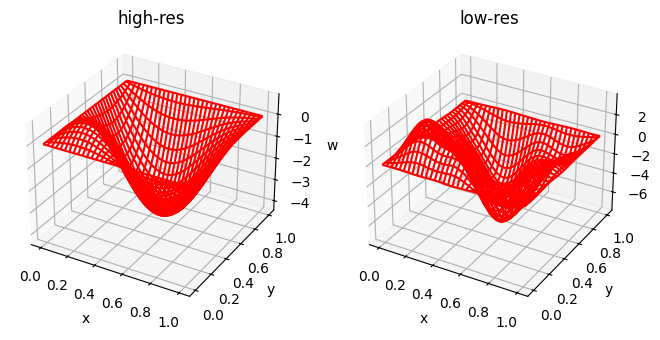

In [55]:
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(121, projection='3d')
X, Y = np.meshgrid(x_high, y_high)
ax1.plot_wireframe(X, Y, z.cpu().data.numpy()[0][0],color='r')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('w')
ax1.set_title('high-res')
ax2 = fig.add_subplot(122, projection='3d')
X, Y = np.meshgrid(x_high,y_high)
ax2.plot_wireframe(X, Y, data_high[2],color='r')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('w')
ax2.set_title('low-res')
plt.show()